# Random forest and one-class SVM for email spam classifier #

To build a spam classifier using the UCR email spam dataset https://archive.ics.uci.edu/ml/datasets/Spambase came from the postmaster and individuals who had filed spam. Please download the data from that website. The collection of non-spam emails came from filed work and personal emails, and hence the word ’george’ and the area code ’650’ are indicators of non-spam. These are useful when constructing a personalized spam filter.


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
df = pd.read_csv('data/spambase.data', header=None)

In [3]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
#spam vs non-spam distribution
df.iloc[:,-1:][57].value_counts()

0    2788
1    1813
Name: 57, dtype: int64

#### Let's build a CART model and visualize the fitted classification tree ####

In [5]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1:]

In [21]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=10,)

# Train Decision Tree Classifer
clf = clf.fit(X,y)

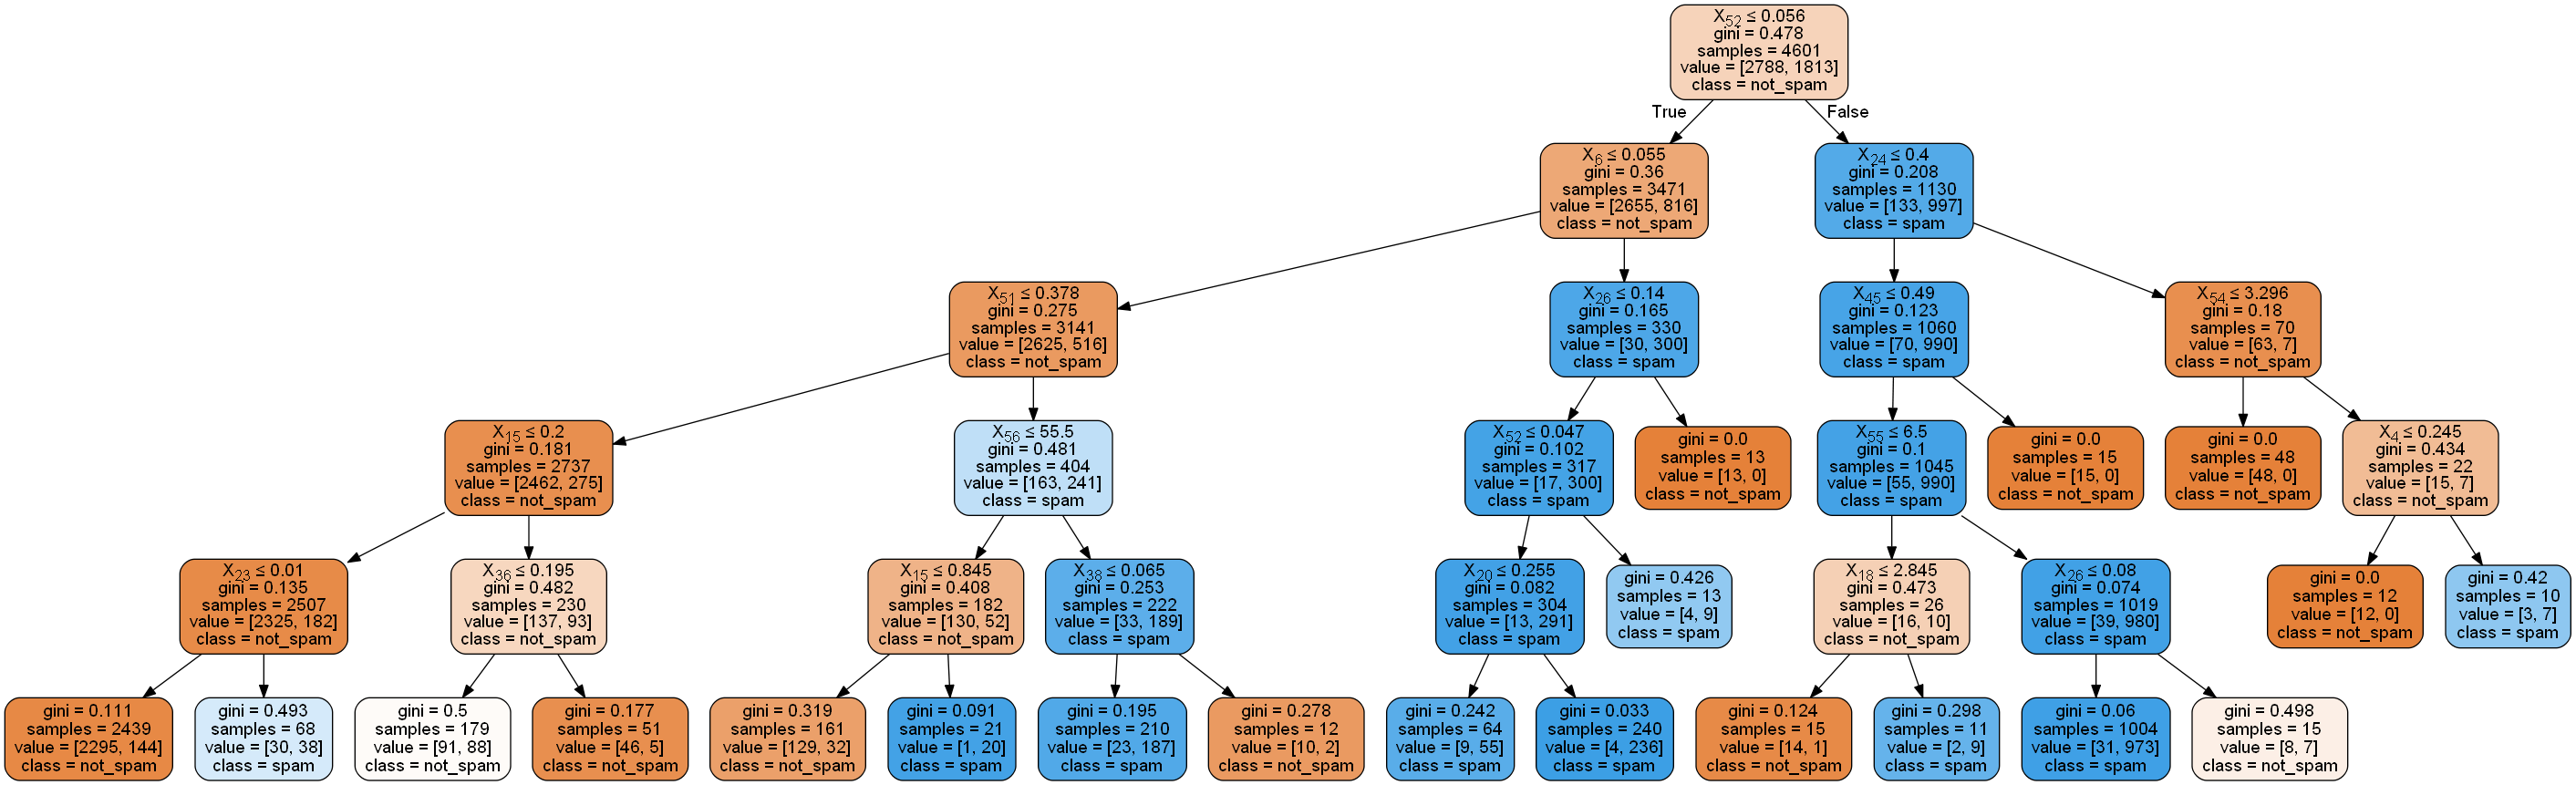

In [22]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['not_spam','spam'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('spam_dtree.png')
Image(graph.create_png())

_____________

#### Now let's also build a random forest model. Partition the data to use the first 80% for training and the remaining 20% for testing. Compare and report the test error for your classification tree and random forest models on testing data. Plot the curve of test error (total misclassification error rate) versus the number of trees for the random forest, and plot the test error for the CART model (which should be a constant with respect to the number of trees) ####

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

In [24]:
#decision tree
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("classification test error rate:",1 - metrics.accuracy_score(y_test, y_pred))

classification test error rate: 0.08360477741585237


In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
# Create RF classifer object
clf = RandomForestClassifier(max_depth=5,
    min_samples_split=10,
    min_samples_leaf=10,)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [27]:
#Random forest
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("classification test error rate:",1 - metrics.accuracy_score(y_test, y_pred))

classification test error rate: 0.08360477741585237


In [28]:
# iterate number of trees 1~50
dic = {}

for i in range(1,101):

    clf = RandomForestClassifier(max_depth=5,
        min_samples_split=10,
        min_samples_leaf=10,
        n_estimators = i)

    clf = clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_test)
    
    dic[i] = 1 - metrics.accuracy_score(y_test, y_pred)

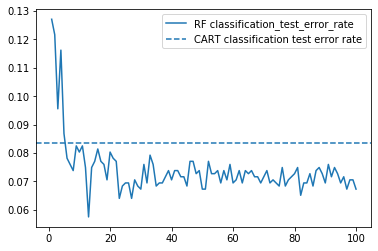

In [39]:
import matplotlib.pylab as plt

lists = sorted(dic.items()) # sorted by key, return a list of tuples

n_tree, classification_test_error_rate = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(n_tree, classification_test_error_rate, label = 'RF classification_test_error_rate')
plt.axhline(y=0.08360477741585237,ls = '--',label='CART classification test error rate') #from the pruned decision tree
plt.legend()
plt.show()

_________________

#### Now let's also use a one-class SVM approach for spam filtering. Partition the data to use the first 80% for training and the remaining 20% for testing. Extract all non-spam emails from the training block (80% of data you have selected) to build the one-class kernel SVM using RBF kernel (you can turn the kernel bandwidth to achieve good performance). Then apply it on the 20% of data reserved for testing (thus this is a novelty detection situation), and report the total misclassification error rate on these testing data. ####

In [83]:
import numpy as np
from sklearn import model_selection
import sklearn.svm as svm

In [76]:
#omly keep non_spams in the new training set
y_train_non_spams = y_train[y_train[57] == 0]

In [81]:
X_train_non_spams = X_train.loc[y_train_non_spams.index, : ]

In [148]:
#One class svm
clf = svm.OneClassSVM(kernel="rbf",nu=0.02)#, gamma=0.1)
             
clf = clf.fit(X_train_non_spams)
#y_pred_train = clf.predict(X_train_non_spams)
y_pred_test = clf.predict(X_test)

# Transform the prediction labels so that non-spam is 0 and spam is 1. 
y_pred_test[y_pred_test == 1] = 0    #non spam
y_pred_test[y_pred_test == -1] = 1  # spam

print("total misclassification error rate: ", 1 - metrics.accuracy_score(y_test, y_pred_test))

total misclassification error rate:  0.2964169381107492


________________________________